In [3]:
%cd /home/luke-padmore/Source/flow-matching-mnist

/home/luke-padmore/Source/flow-matching-mnist


In [4]:
import torchvision
import math
import torch
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os, sys
from models.ode_solvers import euler_solver, rk2_solver
from pathlib import Path 
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Pad(2,padding_mode='constant'),
    transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(root = '/home/luke-padmore/Source/flow-matching-mnist/data',
                                      train=True,
                                      download=True,
                                      transform=transform)
trainloader = DataLoader(trainset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

testset = torchvision.datasets.MNIST(root = '/home/luke-padmore/Source/flow-matching-mnist/data',
                                      train=False,
                                      download=True,
                                      transform=transform)
testloader = DataLoader(trainset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

## Plotting a grid of images

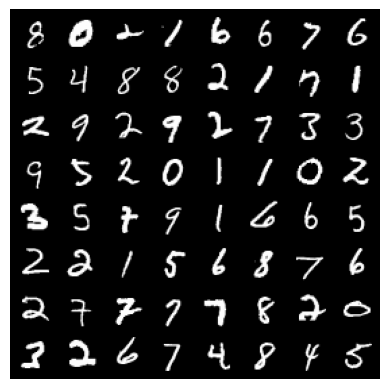

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

grid = torchvision.utils.make_grid((images + 1) / 2,nrow = 8)

plt.imshow(grid.permute(1, 2, 0))  
plt.axis('off')
plt.show()

## Testing training objective

In [5]:
from utils.train import train_loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet([1,32,64,128],8,8,8,128).to(device).to(device)
train_loop(model, trainloader, 100, log_every_step = 1, device = device)

 14%|█▍        | 14/100 [08:49<54:09, 37.79s/it]


KeyboardInterrupt: 

In [ ]:
def vf_learned(model):
    def f(x,t):
        t_tensor = torch.full((x.shape[0], 1, 1, 1), fill_value=t, device=x.device)
        return model(x, t_tensor)
    return f

torch.manual_seed(0)
x0 = torch.randn_like(images).to(device)
# ts,xs = euler_solver(vf_learned(model),x0,0.0,1.0,1000)
ts,xs = rk2_solver(vf_learned(model),x0,0.0,1.0,50)

In [ ]:
grid = torchvision.utils.make_grid((images + 1) / 2,nrow = 8, padding = 2)
plt.imshow(grid.permute(1, 2, 0))  
plt.axis('off')
plt.show()

NameError: name 'torchvision' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2650357..1.367075].


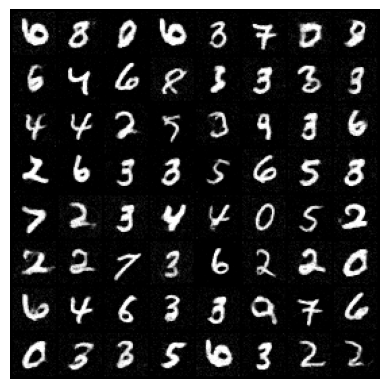

In [ ]:
grid = torchvision.utils.make_grid((xs[-1].cpu() + 1)/2,nrow = 8)
plt.imshow(grid.permute(1, 2, 0))  
plt.axis('off')
plt.show()

## Testing Conditional UNet

In [6]:
from utils.train import train_loop
from models.unet import CondUNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CondUNet([1,32,64,128],11,8,8,8,128).to(device).to(device)
images = images.to(device)
labels = labels.to(device)
t = torch.rand((64,1,1,1), dtype=torch.float, device = device)

## Testing overfitting to a single batch

In [7]:
from utils.train import flow_matching_step_cfg
from tqdm import tqdm
loss_fn = torch.nn.MSELoss()
optim = torch.optim.AdamW(params= model.parameters(),lr = 1e-3)
flow_matching_step_cfg(model,images,labels,0.2,10,loss_fn,device)
model.train()
for epoch in tqdm(range(1000)):
    optim.zero_grad()
    mse = flow_matching_step_cfg(model,images,labels,0.2,10,loss_fn,device)
    mse.backward()
    optim.step()
    if epoch % 100 == 0:
        print(f'Loss = {mse.item()}')


  0%|          | 5/1000 [00:00<01:00, 16.51it/s]

Loss = 2.039052724838257


 11%|█         | 106/1000 [00:03<00:29, 30.73it/s]

Loss = 0.23247264325618744


 21%|██        | 207/1000 [00:07<00:25, 30.66it/s]

Loss = 0.21713842451572418


 30%|███       | 305/1000 [00:10<00:23, 29.26it/s]

Loss = 0.17143000662326813


 40%|████      | 405/1000 [00:13<00:20, 29.54it/s]

Loss = 0.16116183996200562


 50%|█████     | 504/1000 [00:17<00:16, 30.66it/s]

Loss = 0.14161676168441772


 60%|██████    | 604/1000 [00:20<00:12, 30.64it/s]

Loss = 0.1382414996623993


 71%|███████   | 706/1000 [00:23<00:09, 30.72it/s]

Loss = 0.11885906755924225


 80%|████████  | 805/1000 [00:27<00:06, 30.90it/s]

Loss = 0.09733790159225464


 90%|█████████ | 905/1000 [00:30<00:03, 30.66it/s]

Loss = 0.12047518044710159


100%|██████████| 1000/1000 [00:33<00:00, 29.61it/s]


## Testing classifier guidance sampling
Needs debugging :(

In [23]:
from models.ode_solvers import make_vf_cfg, create_samples
model = model.to(device)
f = make_vf_cfg(model,labels,w=1,NULL_ID=10)
create_samples(64,(32,32),rk2_solver,f,50,device=device)

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 128, 32, 32] to have 1 channels, but got 128 channels instead